In [1]:
%matplotlib inline
#encoding:UTF-8
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST-data/', one_hot=True)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [3]:
print "训练数据共："+str(len(data.train.images))
print "测试数据共："+str(len(data.test.images))
print "第一个测试图的维度："+str(data.test.images[0].shape)
print "第一个测试图的真实值："+str(data.test.labels[0])

训练数据共：55000
测试数据共：10000
第一个测试图的维度：(784,)
第一个测试图的真实值：[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28,28)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "label: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

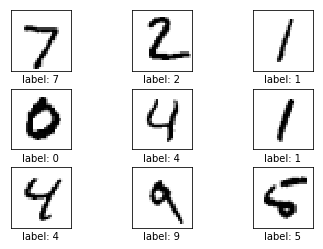

In [5]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = np.argmax(data.test.labels[0:9],1)

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)


In [6]:


# define convolutional layer function
def conv_fun(name,input,input_channels,output_channels):
    # collect all nodes bellow
    with tf.name_scope(name):
        # w for weights
        w = tf.Variable(tf.truncated_normal(stddev=0.5,shape=[5,5,input_channels,output_channels]),name="conv_w")
        # b for biases
        b = tf.Variable(tf.constant(0.5,shape=[output_channels]),name="conv_b")
        # summary histogram of w & b
        tf.summary.histogram("conv_w",w)
        tf.summary.histogram("conv_b",b)
        # convolute 
        conv_layer = tf.nn.conv2d(
            input = input,
            filter = w,
            strides = [1,1,1,1],
            padding="SAME",
            name="conv_op"
        )

        # add biases
        conv_layer = tf.add(conv_layer,b,name="conv_add")
        # relu
        conv_layer = tf.nn.relu(conv_layer,name="conv_relu")
    
        return conv_layer

# define pooling layer function
def pool_fun(name,input):
    # collect all nodes bellow
    with tf.name_scope(name):
        # max pool
        pool_layer = tf.nn.max_pool(
            value = input,
            ksize = [1,2,2,1],
            strides = [1,2,2,1],
            padding="SAME",
            name = "pool_op"
        )
        return pool_layer


#define fully connected layer function     
def fl_fun(name,input,input_channels,output_channels):
    # collect all nodes bellow    
    with tf.name_scope(name):
        # weights & biases
        w = tf.Variable(tf.truncated_normal(stddev=0.5,shape=[input_channels,output_channels]),name="fl_w")
        b = tf.Variable(tf.constant(0.5,shape=[output_channels]),name="fl_b")
        # summary histogram of w & b
        tf.summary.histogram("fl_w",w)
        tf.summary.histogram("fl_b",b)
        # add biases
        fl = tf.add(tf.matmul(input,w),b,name = "fl_add")
        
        return fl


In [7]:
# generate different string
def generate(learning_rate,use_two_conv,use_two_fl):
    str_a = 2 if use_two_conv else 1
    str_b = 2 if use_two_fl else 1
    return "lr_%s,conv=%s,fl=%s" % (learning_rate,str_a,str_b)

In [8]:
# main model to evaluate different conditions 
def minst_model(lr,use_two_conv,use_two_fl):
    # must reset
    tf.reset_default_graph()
    # x for input 
    x = tf.placeholder(tf.float32,[None,784],name="x")
    # reshape x to NHWC format matrix
    x_reshape = tf.reshape(x,[-1,28,28,1],name="x_reshape")
    # summary input images
    tf.summary.image("input_images",x_reshape)
    
    # use two convolutional layers
    if use_two_conv:
        # conv1,shape :[-1,28,28,32]
        conv1 = conv_fun("conv1",x_reshape,1,32)    
        # pool1 ,shape: [-,14,14,32]
        pool1 = pool_fun("pool1",conv1)
        # conv2 ,shape:[-1,14,14,64]
        conv2 = conv_fun("conv2",pool1,32,64)
        # pool2, shape:[-1,7,7,64]
        pool2 = pool_fun("pool2",conv2)
    # only use one conv layer
    else:
        # conv1,shape :[-1,28,28,64]
        conv1 = conv_fun("conv1",x_reshape,1,64)    
        # pool1 ,shape: [-,14,14,64]
        pool1 = pool_fun("pool1",conv1)
        # pool2, shape:[-1,7,7,64]        
        pool2 = pool_fun("pool2",pool1)

    # flat pool2 to shape [-1,7*7*64]
    flat_layer = tf.reshape(pool2,[-1,7*7*64],name="flat_layer")
    
    # use two fully connected layers
    if use_two_fl:
        # fl_1 (fully connected layer 1) ,shape: [-1,7*7*64,1024]
        fl_1 = fl_fun("fl_1",flat_layer,7*7*64,1024)
        # fl_2, shape [-1,10], as logits
        fl_2 = fl_fun("fl_2",fl_1,1024,10)
    # only use one fl
    else:
        # fl_2, shape [-1,10], as logits
        fl_2 = fl_fun("fl_2",flat_layer,7*7*64,10)
        
        
    # predictive y class
    y_pred_cls = tf.arg_max(fl_2,1)

    
    y_true = tf.placeholder(tf.float32,[None,10],name="y_true")
    y_true_cls = tf.arg_max(y_true,1,name="y_true_cls")

    # cost 
    with tf.name_scope("cost"):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=fl_2,name="cross_entropy")
        cost = tf.reduce_mean(cross_entropy)
        # summary cost 
        tf.summary.scalar("cost",cost)
    # use  AdamOptimizer to train the model    
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    # accuracy    
    with tf.name_scope("accuracy"):
        equals = tf.equal(y_pred_cls,y_true_cls)
        accuracy = tf.reduce_mean(tf.cast(equals,dtype=tf.float32))
        # summary accuracy
        tf.summary.scalar("accuracy",accuracy)
        
    # initial session and variables
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    # merge all summaries
    summary_merged = tf.summary.merge_all()
    # write graph and summaries to train writer
    train_writer = tf.summary.FileWriter('./log/train_'+generate(lr,use_two_conv,use_two_fl)    ,graph=session.graph)
    # writw summaries to test writer
    test_writer = tf.summary.FileWriter('./log/test_'+generate(lr,use_two_conv,use_two_fl) )
    
    batch_size = 100;
    with tf.name_scope("train_iterals"):
        for i in range(6000):
            batch = data.train.next_batch(batch_size)
            feed_dict_batch = {x:batch[0],y_true:batch[1]}
            print i
            if i % 5 == 0:
                s,acc =  session.run([summary_merged,accuracy],feed_dict=feed_dict_batch)
                train_writer.add_summary(s,i)
                print 'Train_'+generate(lr,use_two_conv,use_two_fl)+"acc:{:0.1%}".format(acc)
            if i % 10 == 0:
                feed_dict_test = {
                    x : data.test.images,
                    y_true: data.test.labels
                }
                s,acc = session.run([summary_merged,accuracy],feed_dict=feed_dict_test)
                test_writer.add_summary(s,i)
                print 'Test_'+generate(lr,use_two_conv,use_two_fl)+" acc:{:0.1%}".format(acc)
            
            
            session.run(optimizer,feed_dict=feed_dict_batch)    

    

In [ ]:
# different conditions
# learning rate in [0.001,0.0001]
for lr in [0.001,0.0001]:
    # use one or two conv layers
    for use_two_conv in [True,False]:
        # use one or two fl
        for use_two_fl in [True,False]:
            # start model , and evaluate it
            minst_model(lr,use_two_conv,use_two_fl)